<a href="https://colab.research.google.com/github/piyushkushe19/Image-Caption-Generator-using-CNN-and-LSTM-NLP-and-Computer-Vision-/blob/main/Image_Caption_Generatorrrrr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap

plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')

In [4]:
image_path = '/content/drive/MyDrive/Images'
data = pd.read_csv("/content/drive/MyDrive/captions.txt")
data.head()

image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...

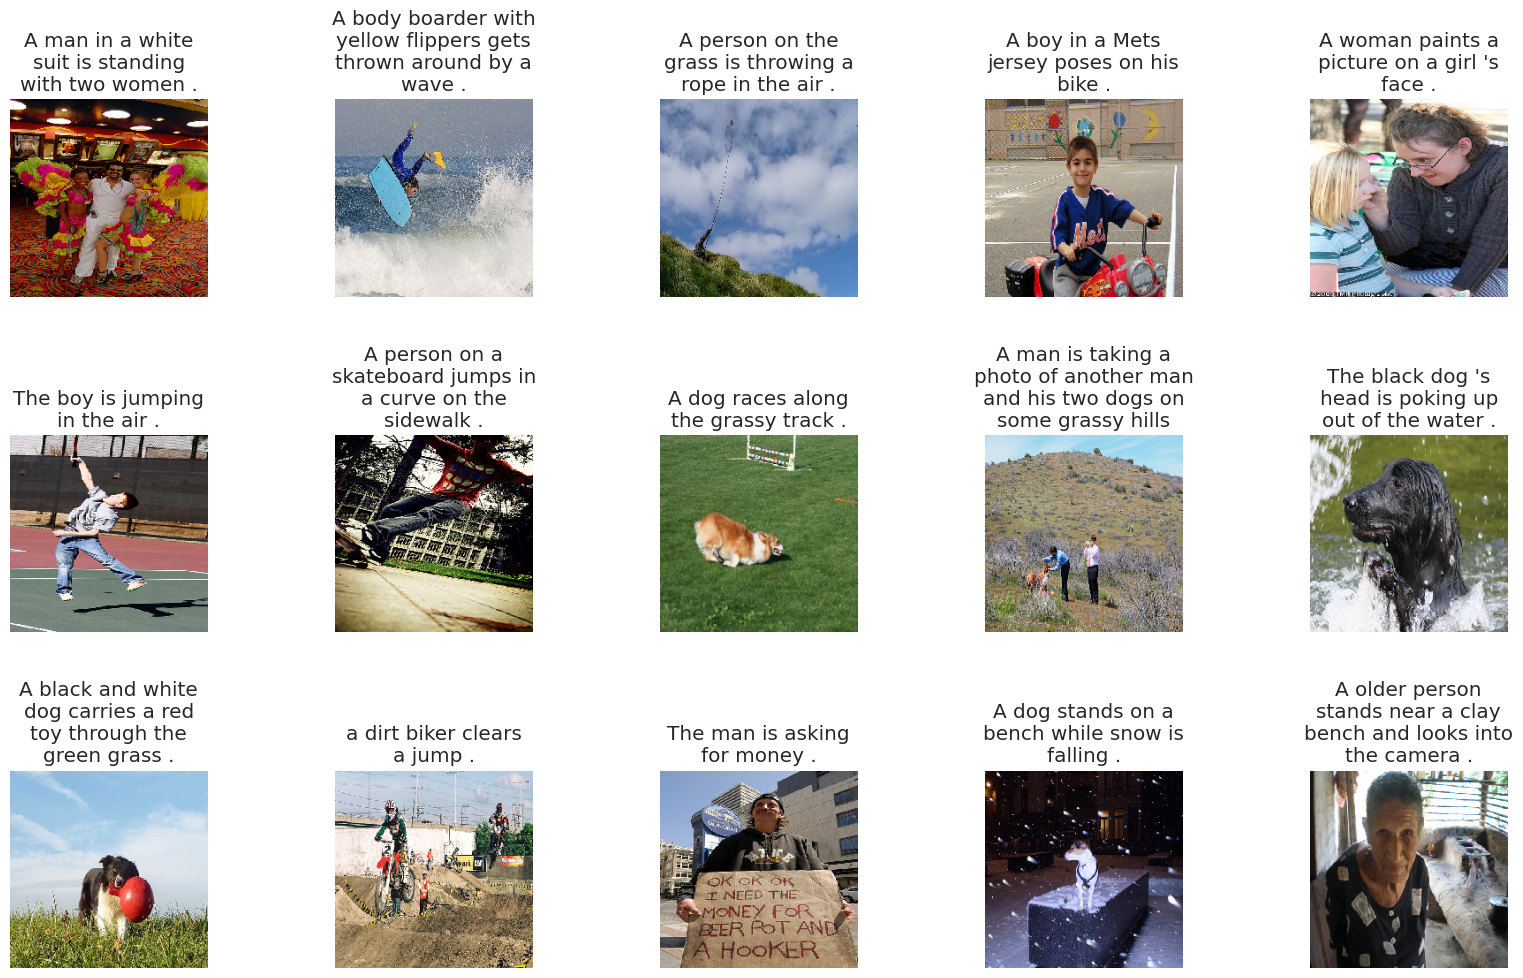

In [5]:
def readImage(path,img_size=224):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.

    return img

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(f"/content/drive/MyDrive/Images/{temp_df.image[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        plt.axis("off")

display_images(data.sample(15))

In [6]:
def text_preprocessing(data):
    data['caption'] = data['caption'].apply(lambda x: x.lower())
    data['caption'] = data['caption'].apply(lambda x: x.replace("[^A-Za-z]",""))
    data['caption'] = data['caption'].apply(lambda x: x.replace("\s+"," "))
    data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))
    data['caption'] = "startseq "+data['caption']+" endseq"

    return data

data = text_preprocessing(data)

captions = data['caption'].tolist()

captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [7]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)

images = data['image'].unique().tolist()
nimages = len(images)

split_index = round(0.85*nimages)
train_images = images[:split_index]
val_images = images[split_index:]

train = data[data['image'].isin(train_images)]
test = data[data['image'].isin(val_images)]

train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

tokenizer.texts_to_sequences([captions[1]])[0]

[1, 18, 315, 63, 195, 116, 2]

In [8]:
from tensorflow.keras.models import load_model
import pickle

# Paths to your saved files
feature_extractor_path = "/content/drive/MyDrive/Image Caption Generatorrrrrrrrr/feature_extractor.keras"
model_path = "/content/drive/MyDrive/Image Caption Generatorrrrrrrrr/model.keras"
tokenizer_path = "/content/drive/MyDrive/Image Caption Generatorrrrrrrrr/tokenizer.pkl"

# Load the models
caption_model = load_model(model_path)
feature_extractor = load_model(feature_extractor_path)

# Load the tokenizer
with open(tokenizer_path, "rb") as f:
    tokenizer = pickle.load(f)


In [9]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import pickle
import os

# load save files
model_path = "/content/drive/MyDrive/Image Caption Generatorrrrrrrrr/model.keras"
tokenizer_path = "/content/drive/MyDrive/Image Caption Generatorrrrrrrrr/tokenizer.pkl"
feature_extractor_path = "/content/drive/MyDrive/Image Caption Generatorrrrrrrrr/feature_extractor.keras"


def generate_and_display_caption(image_path, model_path, tokenizer_path, feature_extractor_path, max_length=34, img_size=224):
    # Load the trained models and tokenizer
    caption_model = load_model(model_path)
    feature_extractor = load_model(feature_extractor_path)

    with open(tokenizer_path, "rb") as f:
        tokenizer = pickle.load(f)

    # Preprocess the image
    img = load_img(image_path, target_size=(img_size, img_size))
    img = img_to_array(img) / 255.0  # Normalize pixel values
    img = np.expand_dims(img, axis=0)
    image_features = feature_extractor.predict(img, verbose=0)  # Extract image features

    # Generate the caption
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = caption_model.predict([image_features, sequence], verbose=0)
        yhat_index = np.argmax(yhat)
        word = tokenizer.index_word.get(yhat_index, None)
        if word is None:
            break
        in_text += " " + word
        if word == "endseq":
            break
    caption = in_text.replace("startseq", "").replace("endseq", "").strip()

    # Display the image with the generated caption
    img = load_img(image_path, target_size=(img_size, img_size))
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.title(caption, fontsize=16, color='blue')
    plt.show()

    return caption # Return the generated caption

In [11]:
pip install nltk rouge-score pycocoevalcap


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.3/104.3 MB 8.7 MB/s eta 0:00:00
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=dc8d563f4a0f8cd48f3a450435f0c831679205a2868d0c6130634a0909cf39fe
  Stored in directory: /root/.cache/pip/wheels/85/9d/af/01feefbe7d55ef5468796f0c68225b6788e85d9d0a281e7a70
Successfully built rouge-score


In [12]:
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.meteor_score import meteor_score
from rouge_score import rouge_scorer
import random


In [13]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')  # WordNet multilingual data (needed sometimes)


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [15]:
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.meteor_score import meteor_score
from rouge_score import rouge_scorer
import random
import numpy as np

def evaluate_model(sample_size=100):  # quick subset
    actual, predicted = [], []
    meteor_scores, rouge_scores = [], []

    # Random subset of validation images
    sample_images = random.sample(list(test['image'].unique()), min(sample_size, len(test)))

    for image in sample_images:
        # Ground-truth captions (tokenized)
        references = [cap.split() for cap in test[test['image']==image]['caption'].tolist()]

        # Generate predicted caption
        image_path = f"/content/drive/MyDrive/Images/{image}"
        pred_caption = generate_caption_only(image_path, model_path, tokenizer_path, feature_extractor_path)

        # Tokenize prediction
        pred_tokens = pred_caption.split()

        predicted.append(pred_tokens)
        actual.append(references)

        # METEOR (per reference set)
        meteor = np.mean([meteor_score([ref], pred_tokens) for ref in references])
        meteor_scores.append(meteor)

        # ROUGE-L
        scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
        rouge = np.mean([scorer.score(' '.join(ref), ' '.join(pred_tokens))['rougeL'].fmeasure for ref in references])
        rouge_scores.append(rouge)

    # BLEU scores
    bleu1 = corpus_bleu(actual, predicted, weights=(1, 0, 0, 0))
    bleu2 = corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))
    bleu3 = corpus_bleu(actual, predicted, weights=(0.33, 0.33, 0.33, 0))
    bleu4 = corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))

    # Print final metrics
    print("\n📊 Caption-Level Evaluation (subset of", sample_size, "images)")
    print("--------------------------------------------------")
    print(f"BLEU-1   : {bleu1*100:.2f}%")
    print(f"BLEU-2   : {bleu2*100:.2f}%")
    print(f"BLEU-3   : {bleu3*100:.2f}%")
    print(f"BLEU-4   : {bleu4*100:.2f}%")


# Run quick evaluation (no image output)
evaluate_model(sample_size=100)


NameError: name 'generate_caption_only' is not defined

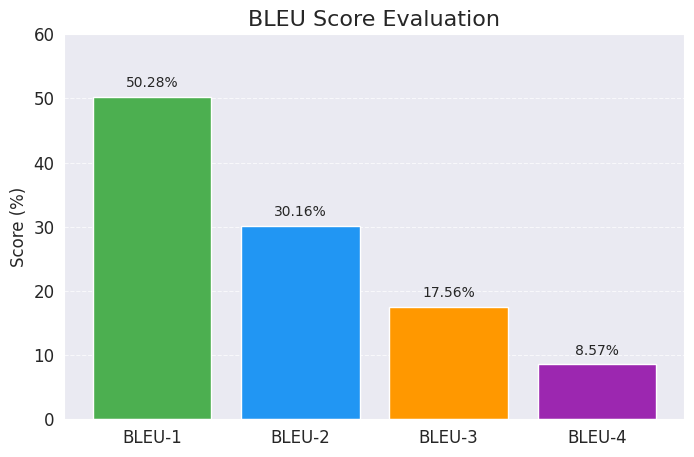

In [ ]:
import matplotlib.pyplot as plt

# Scores for BLEU only
metrics = ['BLEU-1', 'BLEU-2', 'BLEU-3', 'BLEU-4']
scores = [50.28, 30.16, 17.56, 8.57]

# Plot
plt.figure(figsize=(8,5))
bars = plt.bar(metrics, scores, color=['#4CAF50','#2196F3','#FF9800','#9C27B0'])
plt.ylim(0, 60)  # Adjust y-axis

# Add text on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height + 1, f'{height:.2f}%', ha='center', va='bottom', fontsize=10)

plt.title('BLEU Score Evaluation', fontsize=16)
plt.ylabel('Score (%)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


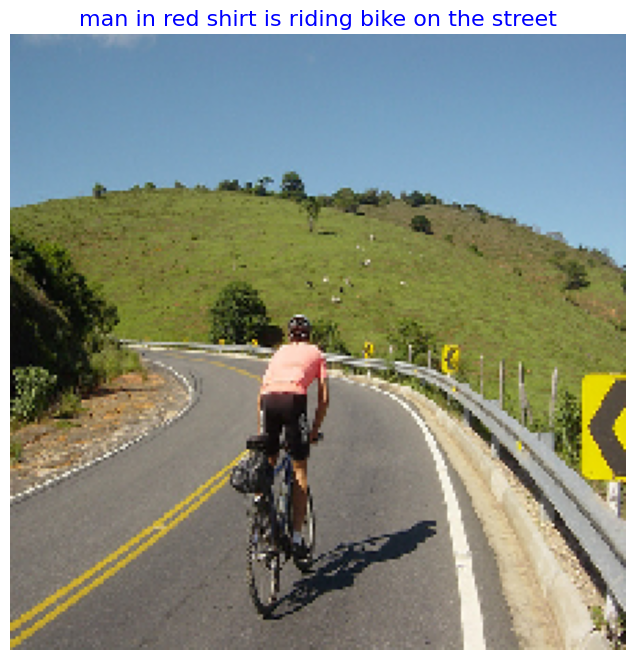

'man in red shirt is riding bike on the street'

In [16]:
image_path = "/content/drive/MyDrive/Images/110595925_f3395c8bd6.jpg"
generate_and_display_caption(image_path, model_path, tokenizer_path, feature_extractor_path)

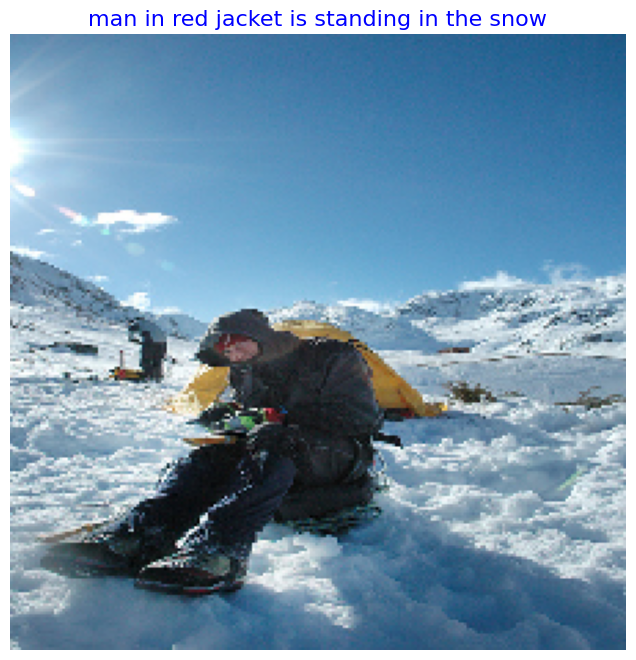

'man in red jacket is standing in the snow'

In [17]:
image_path = "/content/drive/MyDrive/Images/116409198_0fe0c94f3b.jpg"
generate_and_display_caption(image_path, model_path, tokenizer_path, feature_extractor_path)

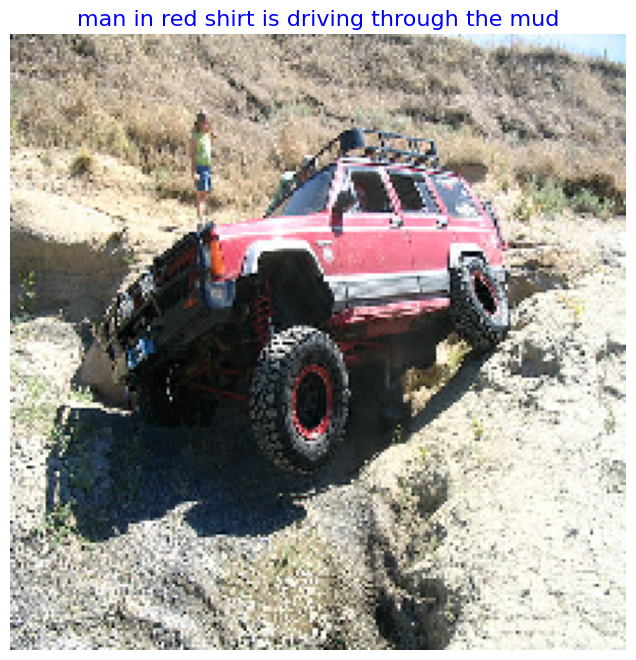

'man in red shirt is driving through the mud'

In [18]:
image_path = "/content/drive/MyDrive/Images/36422830_55c844bc2d.jpg"
generate_and_display_caption(image_path, model_path, tokenizer_path, feature_extractor_path)

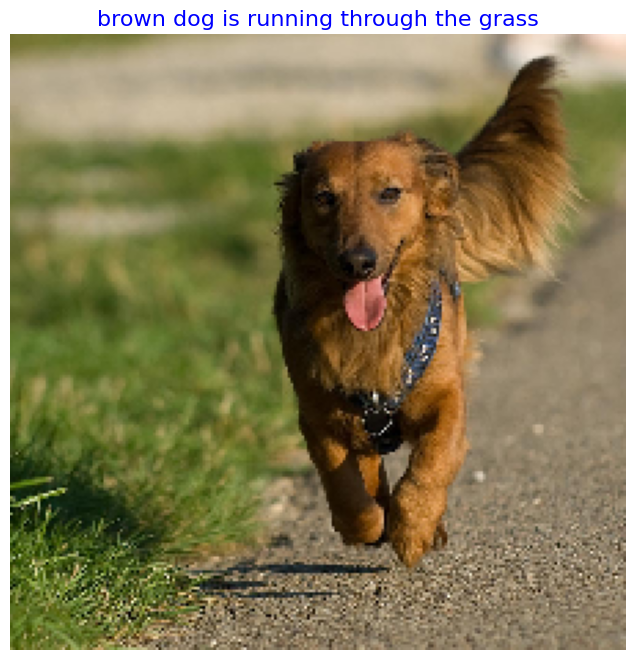

'brown dog is running through the grass'

In [19]:
image_path = "/content/drive/MyDrive/Images/1089181217_ee1167f7af.jpg"
generate_and_display_caption(image_path, model_path, tokenizer_path, feature_extractor_path)

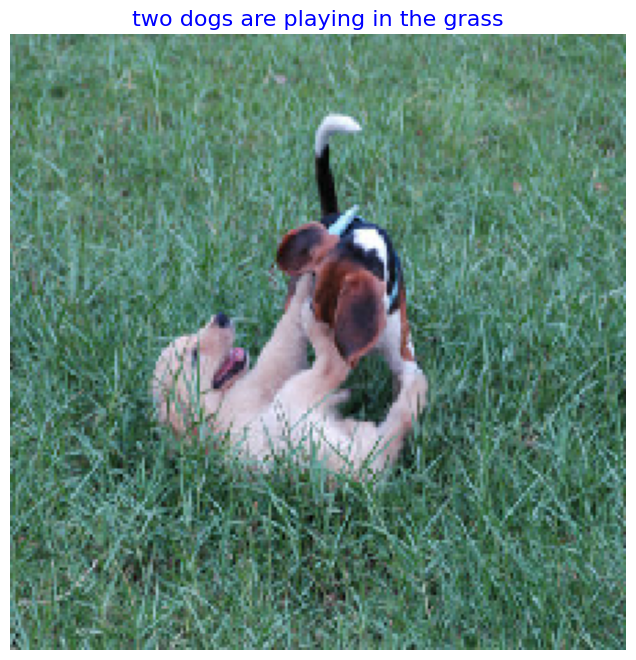

'two dogs are playing in the grass'

In [20]:
image_path = "/content/drive/MyDrive/Images/23445819_3a458716c1.jpg"
generate_and_display_caption(image_path, model_path, tokenizer_path, feature_extractor_path)

In [ ]:
image_path = "/content/drive/MyDrive/Images/55135290_9bed5c4ca3.jpg"
generate_and_display_caption(image_path, model_path, tokenizer_path, feature_extractor_path)

In [ ]:
image_path = "/content/drive/MyDrive/Images/58357057_dea882479e.jpg"
generate_and_display_caption(image_path, model_path, tokenizer_path, feature_extractor_path)

In [ ]:
import numpy as np
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import load_model
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.meteor_score import meteor_score
from rouge_score import rouge_scorer
import random

# Load your trained model
model_path = "/content/drive/MyDrive/Image Caption Generatorrrrrrrrr/model.keras"
caption_model = load_model(model_path)

# Load the feature extractor model and tokenizer from previously defined variables
feature_extractor_path = "/content/drive/MyDrive/Image Caption Generatorrrrrrrrr/feature_extractor.keras"
feature_extractor = load_model(feature_extractor_path)

tokenizer_path = "/content/drive/MyDrive/Image Caption Generatorrrrrrrrr/tokenizer.pkl"
with open(tokenizer_path, "rb") as f:
    tokenizer = pickle.load(f)

# Use the validation_generator created in the previous cell (30f88b5a)

def generate_caption_only(image_features, max_length=34):
    """Generates a caption given image features."""
    in_text = "startseq"
    for _ in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = caption_model.predict([image_features, sequence], verbose=0)
        yhat_index = np.argmax(yhat)
        word = tokenizer.index_word.get(yhat_index, None)
        if word is None:
            break
        in_text += " " + word
        if word == "endseq":
            break
    caption = in_text.replace("startseq", "").replace("endseq", "").strip()
    return caption


# Generate predictions and evaluate
actual_captions = []
predicted_captions = []

print("Generating predictions and evaluating...")

# Iterate through the validation generator
for i in range(len(validation_generator)):
    # Get batch of images and their original captions
    batch_images, batch_actual_captions = validation_generator[i]

    # Extract features for the batch of images
    batch_image_features = feature_extractor.predict(batch_images, verbose=0)

    # Generate captions for each image in the batch
    for j in range(batch_images.shape[0]):
        # Get the actual captions for this image
        # Note: flow_from_dataframe with class_mode='input' returns the filenames as y,
        # we need to look up the actual captions from the test dataframe.
        image_filename = validation_generator.filenames[i * validation_generator.batch_size + j]
        image_actual_captions = test[test['image'] == image_filename]['caption'].tolist()

        # Generate predicted caption
        predicted_caption = generate_caption_only(np.expand_dims(batch_image_features[j], axis=0))

        actual_captions.append([cap.split() for cap in image_actual_captions])
        predicted_captions.append(predicted_caption.split())

    # Optional: Add a progress indicator
    if (i + 1) % 10 == 0:
        print(f"Processed batch {i + 1}/{len(validation_generator)}")


# Calculate metrics
print("\n📊 Caption-Level Evaluation")
print("--------------------------------------------------")

# BLEU scores
bleu1 = corpus_bleu(actual_captions, predicted_captions, weights=(1, 0, 0, 0))
bleu2 = corpus_bleu(actual_captions, predicted_captions, weights=(0.5, 0.5, 0, 0))
bleu3 = corpus_bleu(actual_captions, predicted_captions, weights=(0.33, 0.33, 0.33, 0))
bleu4 = corpus_bleu(actual_captions, predicted_captions, weights=(0.25, 0.25, 0.25, 0.25))

print(f"BLEU-1   : {bleu1*100:.2f}%")
print(f"BLEU-2   : {bleu2*100:.2f}%")
print(f"BLEU-3   : {bleu3*100:.2f}%")
print(f"BLEU-4   : {bleu4*100:.2f}%")

# METEOR (corpus level) - Note: corpus_meteor is not standard in NLTK, doing per-sentence avg
meteor_scores_list = []
for ref_list, pred in zip(actual_captions, predicted_captions):
    meteor_scores_list.append(np.mean([meteor_score([ref], pred) for ref in ref_list]))
meteor_avg = np.mean(meteor_scores_list)
print(f"METEOR   : {meteor_avg*100:.2f}%")

# ROUGE-L (corpus level) - Calculating average ROUGE-L F-measure
rouge_scores_list = []
scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
for ref_list, pred in zip(actual_captions, predicted_captions):
    rouge_scores_list.append(np.mean([scorer.score(' '.join(ref), ' '.join(pred))['rougeL'].fmeasure for ref in ref_list]))
rouge_avg = np.mean(rouge_scores_list)
print(f"ROUGE-L  : {rouge_avg*100:.2f}%")

Generating predictions and evaluating...
Processed batch 10/190
Processed batch 20/190
Processed batch 30/190
Processed batch 40/190
Processed batch 50/190
Processed batch 60/190
Processed batch 70/190
Processed batch 80/190
Processed batch 90/190
Processed batch 100/190
Processed batch 110/190
Processed batch 120/190
Processed batch 130/190
Processed batch 140/190
Processed batch 150/190
Processed batch 160/190
Processed batch 170/190
Processed batch 180/190
Processed batch 190/190

📊 Caption-Level Evaluation
--------------------------------------------------
BLEU-1   : 46.72%
BLEU-2   : 28.34%
BLEU-3   : 16.86%
BLEU-4   : 9.35%
METEOR   : 14.35%
ROUGE-L  : 20.83%


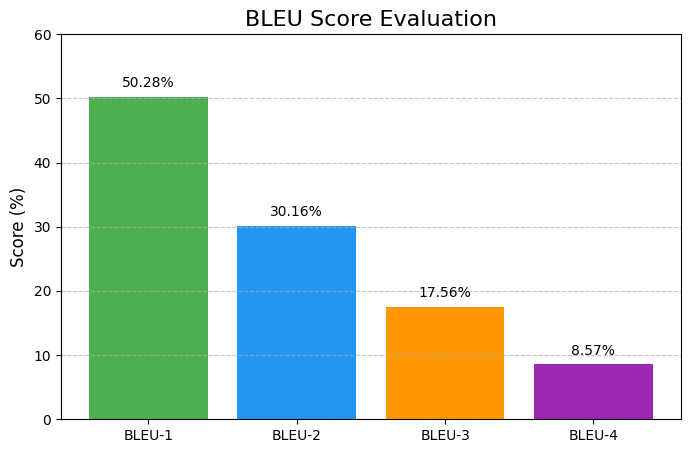

In [2]:
import matplotlib.pyplot as plt

# Scores for BLEU only
metrics = ['BLEU-1', 'BLEU-2', 'BLEU-3', 'BLEU-4']
scores = [50.28, 30.16, 17.56, 8.57]

# Plot
plt.figure(figsize=(8,5))
bars = plt.bar(metrics, scores, color=['#4CAF50','#2196F3','#FF9800','#9C27B0'])
plt.ylim(0, 60)  # Adjust y-axis

# Add text on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height + 1, f'{height:.2f}%', ha='center', va='bottom', fontsize=10)

plt.title('BLEU Score Evaluation', fontsize=16)
plt.ylabel('Score (%)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
